<a href="https://colab.research.google.com/github/Algebraistponey/Hate-speech-nlp-detection/blob/main/TFIDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as panda
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
import string
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer as VS
import warnings

In [ ]:
url= 'https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/master/data/labeled_data.csv'
df = panda.read_csv(url)
df

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [ ]:
# collecting only the tweets from the csv file into a variable name tweet
tweet=df.tweet

In [ ]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words("english")

#extending the stopwords to include other words used in twitter such as retweet(rt) etc.
other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)
stemmer = PorterStemmer()

def preprocess(tweet):  
    
    # removal of extra spaces
    regex_pat = re.compile(r'\s+')
    tweet_space = tweet.str.replace(regex_pat, ' ')

    # removal of @name[mention]
    regex_pat = re.compile(r'@[\w\-]+')
    tweet_name = tweet_space.str.replace(regex_pat, '')

    # removal of links[https://abc.com]
    giant_url_regex =  re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
            '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    tweets = tweet_name.str.replace(giant_url_regex, '')
    
    # removal of punctuations and numbers
    punc_remove = tweets.str.replace("[^a-zA-Z]", " ")
    # remove whitespace with a single space
    newtweet=punc_remove.str.replace(r'\s+', ' ')
    # remove leading and trailing whitespace
    newtweet=newtweet.str.replace(r'^\s+|\s+?$','')
    # replace normal numbers with numbr
    newtweet=newtweet.str.replace(r'\d+(\.\d+)?','numbr')
    # removal of capitalization
    tweet_lower = newtweet.str.lower()
    
    # tokenizing
    tokenized_tweet = tweet_lower.apply(lambda x: x.split())
    
    # removal of stopwords
    tokenized_tweet=  tokenized_tweet.apply(lambda x: [item for item in x if item not in stopwords])
    
    # stemming of the tweets
    tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) 
    
    for i in range(len(tokenized_tweet)):
        tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
        tweets_p= tokenized_tweet
    
    return tweets_p

processed_tweets = preprocess(tweet)   

df['processed_tweets'] = processed_tweets
print(df[["tweet","processed_tweets"]].head(10))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
                                               tweet                                   processed_tweets
0  !!! RT @mayasolovely: As a woman you shouldn't...  woman complain clean hous amp man alway take t...
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  boy dat cold tyga dwn bad cuffin dat hoe st place
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...         dawg ever fuck bitch start cri confus shit
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...                                   look like tranni
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...     shit hear might true might faker bitch told ya
5  !!!!!!!!!!!!!!!!!!"@T_Madison_x: The shit just...      shit blow claim faith somebodi still fuck hoe
6  !!!!!!"@__BrighterDays: I can not just sit up ...              sit hate anoth bitch got much shit go
7  !!!!&#8220;@selfiequeenbri: cause I'm tired of

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),max_df=0.75, min_df=5, max_features=10000)

# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(df['processed_tweets'])
tfidf

<24783x6441 sparse matrix of type '<class 'numpy.float64'>'
	with 189618 stored elements in Compressed Sparse Row format>

In [ ]:
X = tfidf
y = df['class'].astype(int)
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
model = LogisticRegression().fit(X_train_tfidf,y_train)
y_preds = model.predict(X_test_tfidf)
report = classification_report( y_test, y_preds )
print(report)
accuracylog=accuracy_score(y_test,y_preds)
print("Logistic Regression, Accuracy Score:" , accuracylog)

              precision    recall  f1-score   support

           0       0.56      0.18      0.27       290
           1       0.92      0.96      0.94      3832
           2       0.85      0.84      0.85       835

    accuracy                           0.90      4957
   macro avg       0.77      0.66      0.68      4957
weighted avg       0.88      0.90      0.88      4957

Logistic Regression, Accuracy Score: 0.8975186604801291


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
support =LinearSVC(random_state=20)
support.fit(X_train_tfidf,y_train)
y_preds = support.predict(X_test_tfidf)
accuracysvm=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("SVM, Accuracy Score:" , accuracysvm)



              precision    recall  f1-score   support

           0       0.46      0.26      0.33       290
           1       0.92      0.95      0.94      3832
           2       0.83      0.85      0.84       835

    accuracy                           0.89      4957
   macro avg       0.74      0.69      0.70      4957
weighted avg       0.88      0.89      0.89      4957

SVM, Accuracy Score: 0.8932822271535202


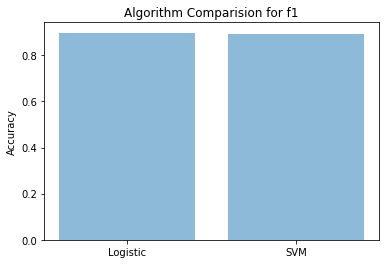

In [ ]:


objects = ('Logistic', 'SVM')
y_pos = np.arange(len(objects))
performance = [accuracylog, accuracysvm]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Algorithm Comparision for f1')
plt.show()